# Kaggle fishery images

In [0]:
# If you want to connect your google drive, you can execute this block
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# load libraries
import os, time, json, re
import itertools, collections
import argparse, pickle, random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.nn import functional as F
import torchvision.transforms as T
from torchvision import models

import io
import requests
import PIL
from PIL import Image
import cv2

from collections import namedtuple
import matplotlib.pyplot as plt

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
# For images saved in gdrive created from faster rcnn (didn't continue training classifier at the time)
# cannot use cp -r due to so many items and taking long time...
import os.path as osp
from shutil import copyfile
np.random.seed(0)

im_path = '/content/drive/My Drive/DL_projects/cv_fish/Faster_RCNN/test_cls'
if not os.path.exists('/content/test_cls'):
    os.mkdir('/content/test_cls')

files = os.listdir(im_path)
np.random.shuffle(files)
for imfile in files[:100]:
    copyfile(osp.join(im_path, imfile), osp.join('/content/test_cls', imfile))

In [0]:
!ls

drive  fish_bbox  sample_data  test_cls  train	train_cls


## Download data

In [0]:
!mkdir /root/.kaggle
!cp /content/drive/My\ Drive/DL_projects/Data/kaggle.json /root/.kaggle/

In [0]:
!kaggle competitions download -c the-nature-conservancy-fisheries-monitoring -f train.zip

100% 829M/832M [00:06<00:00, 130MB/s]
100% 832M/832M [00:07<00:00, 124MB/s]


In [0]:
!unzip -q train.zip

In [0]:
!rm train.zip

In [0]:
!rm train/.DS_Store

In [0]:
!rm -r __MACOSX

In [0]:
!cp -r /content/drive/My\ Drive/DL_projects/Data/fish_monitor/fish_bbox ./

In [0]:
!mkdir train_cls

## Prepare data

In [0]:
nb_each_class

{'ALB': 1719,
 'BET': 200,
 'DOL': 117,
 'LAG': 67,
 'NoF': 465,
 'OTHER': 299,
 'SHARK': 176,
 'YFT': 734}

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


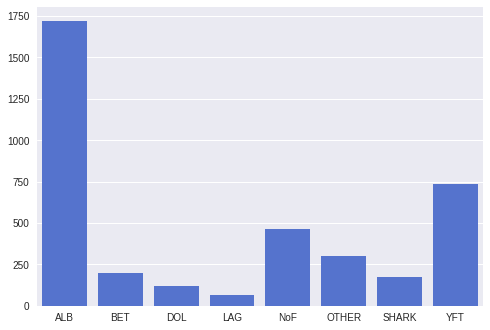

In [0]:
sns.barplot(x=pd.Series(nb_each_class).index, y=pd.Series(nb_each_class).values, color='royalblue');

In [0]:
data_path = '/content'  # path of data files
label_clss = ['DOL', 'LAG', 'BET', 'OTHER', 'SHARK', 'YFT', 'ALB']
no_bbs = ['img_00568.jpg', 'img_01958.jpg', 'img_07008.jpg', 'img_00425.jpg',
          'img_04798.jpg', 'img_06460.jpg', 'img_02292.jpg', 'img_00576.jpg',
          'img_00379.jpg', 'img_06773.jpg', 'img_05444.jpg', 'img_06082.jpg',
          'img_03183.jpg', 'img_04558.jpg', 'img_02785.jpg']

In [0]:
!cp -r /content/train/NoF /content/train_cls/

In [0]:
for c in label_clss:
    if not os.path.exists(f'/content/train_cls/{c}'):
        os.mkdir(f'/content/train_cls/{c}')

In [0]:
gt = {}
for c in label_clss:
    with open(os.path.join(data_path, 'fish_bbox', c.lower()+'_labels.json')) as f:
        gt[c] = json.load(f)

In [0]:
all_files = []
for c in label_clss:
    im_files = os.listdir(os.path.join(data_path, 'train', c))
    all_files += [c+'/'+f for f in im_files if f not in no_bbs]

In [0]:
%%time
for fpath in all_files:
    im = Image.open(os.path.join(data_path, 'train', fpath))
    clss, fname = fpath.split('/')
    mask = list(map(lambda x: x['filename'].split('/')[-1]==fname, gt[clss]))
    bbs = np.array(gt[clss])[mask][0]['annotations']

    boxes = [[b['x'], b['y'], (b['x']+b['width']), (b['y']+b['height'])] for b in bbs]
    for i in range(len(boxes)):
        im.crop(boxes[i]).save(os.path.join(data_path, 'train_cls', clss, f'{i}_'+fname))

CPU times: user 53 s, sys: 690 ms, total: 53.7 s
Wall time: 54.1 s


## Load model

In [0]:
dtype = torch.cuda.FloatTensor

class AdaptiveConcatPool2d(nn.Module):
    "Layer that concats `AdaptiveAvgPool2d` and `AdaptiveMaxPool2d`."
    def __init__(self, output_size=None):
        "Output will be 2*output_size or 2 if output_size is None"
        super().__init__()
        self.output_size = output_size or 1
        self.ap = nn.AdaptiveAvgPool2d(self.output_size)
        self.mp = nn.AdaptiveMaxPool2d(self.output_size)
    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)

class Flatten(nn.Module):
    def forward(self, x): return x.view(x.size(0), -1)

class ResNetFish(nn.Module):
    def __init__(self, net):
        super().__init__()
        adapt_pool = AdaptiveConcatPool2d((1,1))
        flatten = Flatten()
        fc = nn.Linear(in_features=2048*2, out_features=8)
        nn.init.xavier_uniform_(fc.weight)
        nn.init.constant_(fc.bias, 0.)
        
        self.group_1 = nn.Sequential(*[c for c in net.children()][:5])
        self.group_2 = nn.Sequential(*[c for c in net.children()][5:8])
        self.group_3 = nn.Sequential(adapt_pool, flatten, fc)
    
    def forward(self, x):
        x = self.group_1(x)
        x = self.group_2(x)
        out = self.group_3(x)
        return out

def load_model():
    net = models.resnet50(pretrained=True)
    model = ResNetFish(net)
    model.load_state_dict(torch.load('/content/drive/My Drive/DL_projects/cv_fish/rn50_ft_epk_3_pl.pth'))
    return model

In [0]:
net = load_model()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:06<00:00, 15.5MB/s]


## Visualization (grad-CAM)

In [0]:
# load image
def read_rand_img(c):
    f = np.random.choice(os.listdir(data_path+'/train_cls/'+c), 1)[0]
    img = Image.open(os.path.join(data_path,'train_cls',c,f))
    return img

# preprocess input images
def preprocess(img):
    transform = T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(img)

# compute gradients
def compute_backprop(X, y, model):
    """input: tensors X, y; pytorch model"""
    model.eval()
    scores = model(X)
    correct_scores = scores.gather(1, y.view(-1, 1)).squeeze()
    loss = correct_scores.sum()
    loss.backward()

# forward propagation for inference
def get_preds(img, model):
    """input img tensor, pytorch model"""
    model.eval()
    logit = model(img)   # (1, 8)
    h_x = F.softmax(logit, dim=1).data.squeeze()   # (8,) probability of each class for this image
    probs, idx = h_x.sort(0, True)
    probs = probs.cpu().numpy()
    idx = idx.cpu().numpy()
    return probs, idx

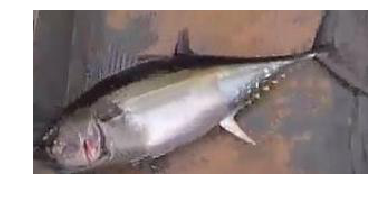

In [0]:
img_pil = read_rand_img('ALB')

plt.axis('off')
plt.imshow(img_pil)

In [0]:
net = net.type(dtype)
img_tensor = preprocess(img_pil).type(dtype)   # (1, 3, 224, 224)

In [0]:
label_clss = ['NoF', 'DOL', 'LAG', 'BET', 'OTHER', 'SHARK', 'YFT', 'ALB']

# output the predictions
probs, idx = get_preds(img_tensor, net)
idx[:5]

array([7, 6, 4, 0, 3])

In [0]:
# see the output classes
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], label_clss[idx[i]]))

0.830 -> ALB
0.073 -> YFT
0.037 -> OTHER
0.032 -> NoF
0.009 -> BET


In [0]:
# feature extractor
def extract_feature(x):
    net.eval()
    return net.group_2(net.group_1(x))

class Net_classifier(nn.Module):
    def forward(self, x): return net.group_3(x)

class GradCAM(nn.Module):
    def __init__(self):
        super(GradCAM, self).__init__()
        self.ap = nn.AdaptiveAvgPool2d(1)
    
    def forward(self, feature_maps, feature_grads):
        # features size: (1, k, h, w)
        map_weights = self.ap(feature_grads)   # (1, k, 1, 1)
        maps = torch.sum(map_weights * feature_maps, 1)   # (1, h, w)
        grad_cam = F.relu(maps.squeeze(0))
        return grad_cam

def imresize(img, size):
    im = Image.fromarray(img)
    return np.array(im.resize(size, PIL.Image.BICUBIC))

def returnCAM(feature_maps, class_idx):
    # generate the class activation maps (CAMs) upsample to 256x256
    size_upsample = (256, 256)
    net_classifier = Net_classifier()
    
    feature_maps = feature_maps.type(dtype)
    feature_maps.requires_grad_()

    output_cam = []
    for idx in class_idx:
        compute_backprop(feature_maps, torch.cuda.LongTensor([idx]), net_classifier)
        gradCAM = GradCAM()
        cam = gradCAM(feature_maps, feature_maps.grad).detach().cpu().numpy()
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        cam = np.uint8(255 * cam)
        output_cam.append(imresize(cam, size_upsample))
    return output_cam

In [0]:
final_conv_feature = extract_feature(img_tensor).detach().clone()   # output of final conv layer (after relu)
CAMs = returnCAM(final_conv_feature, [idx[0], idx[1]])

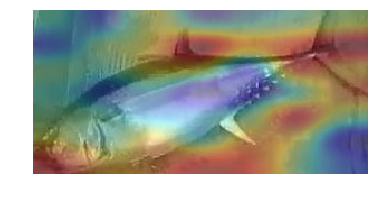

In [0]:
width, height = img_pil.size
heatmap = imresize(CAMs[0], (width, height))

plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.3)
plt.show()

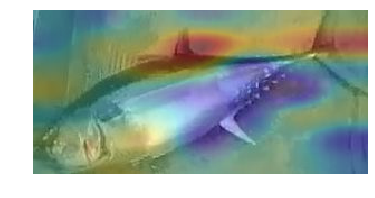

In [0]:
heatmap = imresize(CAMs[1], (width, height))

plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.3)
plt.show()

## Other fish

### YFT

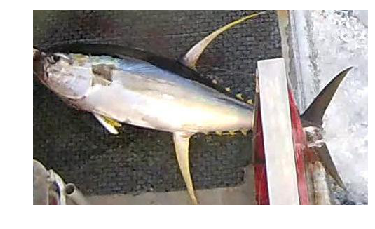

In [0]:
img_pil = read_rand_img('YFT')

plt.axis('off')
plt.imshow(img_pil);

In [0]:
# output the predictions
img_tensor = preprocess(img_pil).type(dtype)   # (1, 3, 224, 224)
probs, idx = get_preds(img_tensor, net)
idx[:5]

array([6, 7, 5, 1, 0])

In [0]:
# see the output classes
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], label_clss[idx[i]]))

0.818 -> YFT
0.110 -> ALB
0.032 -> SHARK
0.014 -> DOL
0.012 -> NoF


In [0]:
final_conv_feature = extract_feature(img_tensor).detach().clone()   # output of final conv layer (after relu)
CAMs = returnCAM(final_conv_feature, [idx[0], idx[1]])

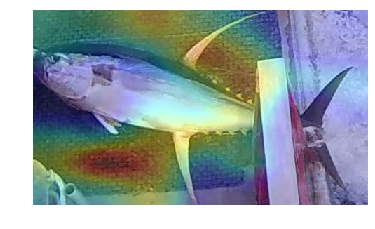

In [0]:
width, height = img_pil.size
heatmap = imresize(CAMs[0], (width, height))

plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.3)
plt.show()

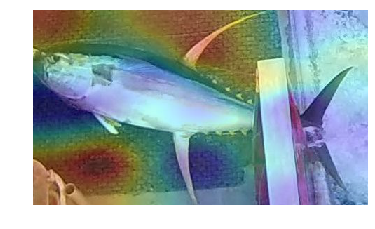

In [0]:
width, height = img_pil.size
heatmap = imresize(CAMs[1], (width, height))

plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.3)
plt.show()

### DOL

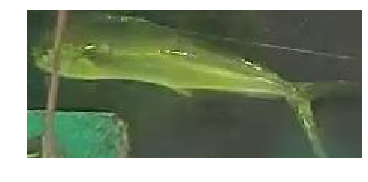

In [0]:
img_pil = read_rand_img('DOL')

plt.axis('off')
plt.imshow(img_pil);

In [0]:
# output the predictions
img_tensor = preprocess(img_pil).type(dtype)   # (1, 3, 224, 224)
probs, idx = get_preds(img_tensor, net)
idx[:5]

array([1, 7, 4, 6, 0])

In [0]:
# see the output classes
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], label_clss[idx[i]]))

0.884 -> DOL
0.057 -> ALB
0.024 -> OTHER
0.019 -> YFT
0.006 -> NoF


In [0]:
final_conv_feature = extract_feature(img_tensor).detach().clone()   # output of final conv layer (after relu)
CAMs = returnCAM(final_conv_feature, [idx[0], idx[1]])

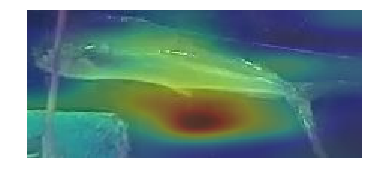

In [0]:
width, height = img_pil.size
heatmap = imresize(CAMs[0], (width, height))

plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.3)
plt.show()

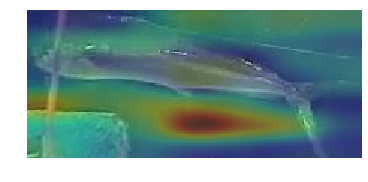

In [0]:
width, height = img_pil.size
heatmap = imresize(CAMs[1], (width, height))

plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.3)
plt.show()

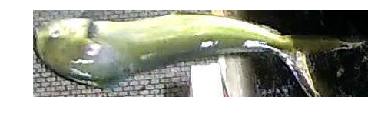

In [0]:
img_pil = read_rand_img('DOL')

plt.axis('off')
plt.imshow(img_pil);

In [0]:
# output the predictions
img_tensor = preprocess(img_pil).type(dtype)   # (1, 3, 224, 224)
probs, idx = get_preds(img_tensor, net)
idx[:5]

array([1, 7, 6, 0, 4])

In [0]:
# see the output classes
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], label_clss[idx[i]]))

0.389 -> DOL
0.218 -> ALB
0.161 -> YFT
0.096 -> NoF
0.071 -> OTHER


In [0]:
final_conv_feature = extract_feature(img_tensor).detach().clone()   # output of final conv layer (after relu)
CAMs = returnCAM(final_conv_feature, [idx[0], idx[1]])

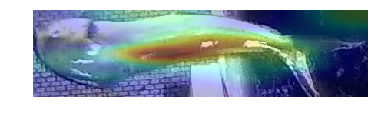

In [0]:
width, height = img_pil.size
heatmap = imresize(CAMs[0], (width, height))

plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.3)
plt.show()

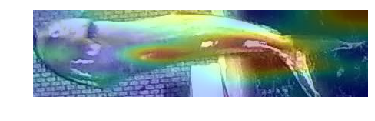

In [0]:
heatmap = imresize(CAMs[1], (width, height))

plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.3)
plt.show()

### LAG

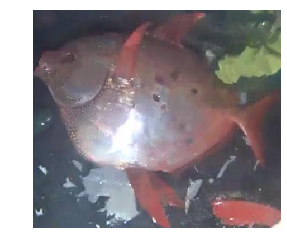

In [0]:
img_pil = read_rand_img('LAG')

plt.axis('off')
plt.imshow(img_pil);

In [0]:
# output the predictions
img_tensor = preprocess(img_pil).type(dtype)   # (1, 3, 224, 224)
probs, idx = get_preds(img_tensor, net)
idx[:5]

array([2, 7, 3, 6, 1])

In [0]:
# see the output classes
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], label_clss[idx[i]]))

0.918 -> LAG
0.039 -> ALB
0.025 -> BET
0.008 -> YFT
0.003 -> DOL


In [0]:
final_conv_feature = extract_feature(img_tensor).detach().clone()   # output of final conv layer (after relu)
CAMs = returnCAM(final_conv_feature, [idx[0]])

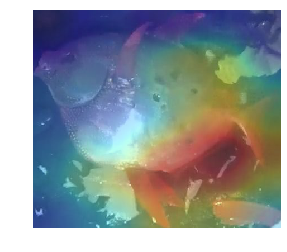

In [0]:
width, height = img_pil.size
heatmap = imresize(CAMs[0], (width, height))

plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.3)
plt.show()

### SHARK

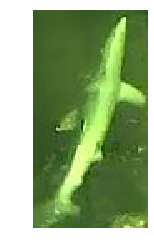

In [0]:
img_pil = read_rand_img('SHARK')

plt.axis('off')
plt.imshow(img_pil);

In [0]:
# output the predictions
img_tensor = preprocess(img_pil).type(dtype)   # (1, 3, 224, 224)
probs, idx = get_preds(img_tensor, net)
idx[:5]

array([5, 7, 6, 4, 3])

In [0]:
# see the output classes
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], label_clss[idx[i]]))

0.875 -> SHARK
0.078 -> ALB
0.024 -> YFT
0.018 -> OTHER
0.002 -> BET


In [0]:
final_conv_feature = extract_feature(img_tensor).detach().clone()   # output of final conv layer (after relu)
CAMs = returnCAM(final_conv_feature, [idx[0]])

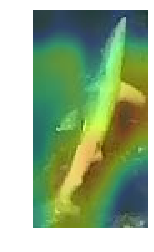

In [0]:
width, height = img_pil.size
heatmap = imresize(CAMs[0], (width, height))

plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.3)
plt.show()

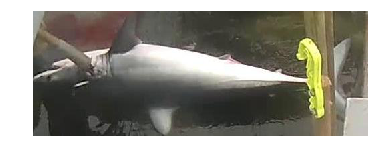

In [0]:
img_pil = read_rand_img('SHARK')

plt.axis('off')
plt.imshow(img_pil);

In [0]:
# output the predictions
img_tensor = preprocess(img_pil).type(dtype)   # (1, 3, 224, 224)
probs, idx = get_preds(img_tensor, net)
idx[:5]

array([5, 6, 7, 4, 1])

In [0]:
# see the output classes
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], label_clss[idx[i]]))

0.933 -> SHARK
0.040 -> YFT
0.010 -> ALB
0.007 -> OTHER
0.004 -> DOL


In [0]:
final_conv_feature = extract_feature(img_tensor).detach().clone()   # output of final conv layer (after relu)
CAMs = returnCAM(final_conv_feature, [idx[0], idx[1]])

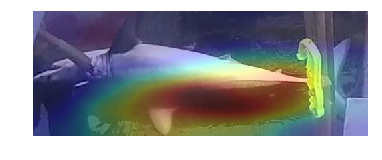

In [0]:
width, height = img_pil.size
heatmap = imresize(CAMs[0], (width, height))

plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.3)
plt.show()

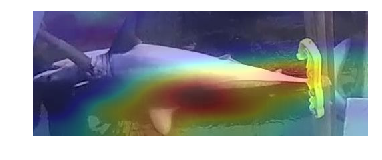

In [0]:
heatmap = imresize(CAMs[1], (width, height))

plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.3)
plt.show()

### BET

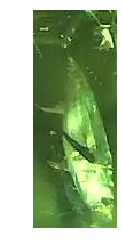

In [0]:
img_pil = read_rand_img('BET')

plt.axis('off')
plt.imshow(img_pil);

In [0]:
# output the predictions
img_tensor = preprocess(img_pil).type(dtype)   # (1, 3, 224, 224)
probs, idx = get_preds(img_tensor, net)
idx[:5]

array([7, 3, 4, 5, 6])

In [0]:
# see the output classes
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], label_clss[idx[i]]))

0.411 -> ALB
0.218 -> BET
0.141 -> OTHER
0.116 -> SHARK
0.094 -> YFT


In [0]:
final_conv_feature = extract_feature(img_tensor).detach().clone()   # output of final conv layer (after relu)
CAMs = returnCAM(final_conv_feature, [idx[0], idx[1]])

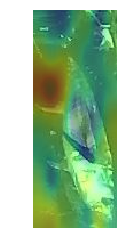

In [0]:
width, height = img_pil.size
heatmap = imresize(CAMs[0], (width, height))

plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.3)
plt.show()

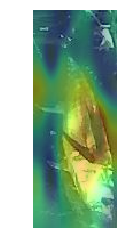

In [0]:
width, height = img_pil.size
heatmap = imresize(CAMs[1], (width, height))

plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.3)
plt.show()

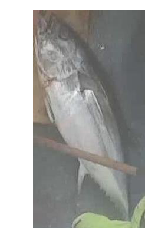

In [0]:
img_pil = read_rand_img('BET')

plt.axis('off')
plt.imshow(img_pil);

In [0]:
# output the predictions
img_tensor = preprocess(img_pil).type(dtype)   # (1, 3, 224, 224)
probs, idx = get_preds(img_tensor, net)
idx[:5]

array([3, 7, 6, 4, 5])

In [0]:
# see the output classes
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], label_clss[idx[i]]))

0.421 -> BET
0.209 -> ALB
0.161 -> YFT
0.093 -> OTHER
0.044 -> SHARK


In [0]:
final_conv_feature = extract_feature(img_tensor).detach().clone()   # output of final conv layer (after relu)
CAMs = returnCAM(final_conv_feature, [idx[0], idx[1]])

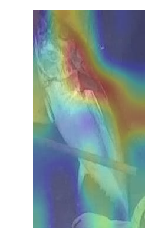

In [0]:
width, height = img_pil.size
heatmap = imresize(CAMs[0], (width, height))

plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.3)
plt.show()

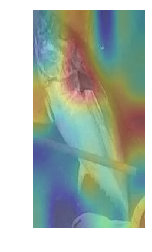

In [0]:
heatmap = imresize(CAMs[1], (width, height))

plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.3)
plt.show()

### OTHER

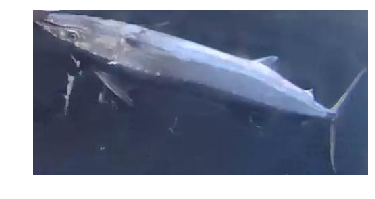

In [0]:
img_pil = read_rand_img('OTHER')

plt.axis('off')
plt.imshow(img_pil);

In [0]:
# output the predictions
img_tensor = preprocess(img_pil).type(dtype)   # (1, 3, 224, 224)
probs, idx = get_preds(img_tensor, net)
idx[:5]

array([4, 7, 3, 5, 1])

In [0]:
# see the output classes
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], label_clss[idx[i]]))

0.971 -> OTHER
0.010 -> ALB
0.009 -> BET
0.005 -> SHARK
0.001 -> DOL


In [0]:
final_conv_feature = extract_feature(img_tensor).detach().clone()   # output of final conv layer (after relu)
CAMs = returnCAM(final_conv_feature, [idx[0]])

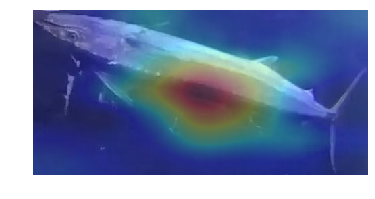

In [0]:
width, height = img_pil.size
heatmap = imresize(CAMs[0], (width, height))

plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.3)
plt.show()

### NoF

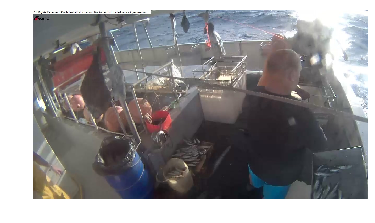

In [0]:
img_pil = read_rand_img('NoF')

plt.axis('off')
plt.imshow(img_pil);

In [0]:
# output the predictions
img_tensor = preprocess(img_pil).type(dtype)   # (1, 3, 224, 224)
probs, idx = get_preds(img_tensor, net)
idx[:5]

array([0, 7, 1, 6, 4])

In [0]:
# see the output classes
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], label_clss[idx[i]]))

0.756 -> NoF
0.156 -> ALB
0.028 -> DOL
0.023 -> YFT
0.022 -> OTHER


In [0]:
final_conv_feature = extract_feature(img_tensor).detach().clone()   # output of final conv layer (after relu)
CAMs = returnCAM(final_conv_feature, [idx[0], idx[1]])

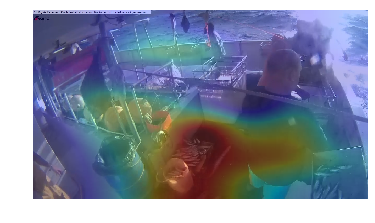

In [0]:
width, height = img_pil.size
heatmap = imresize(CAMs[0], (width, height))

plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.3)
plt.show()

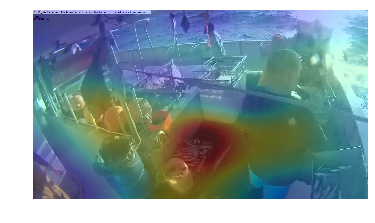

In [0]:
heatmap = imresize(CAMs[1], (width, height))

plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.3)
plt.show()

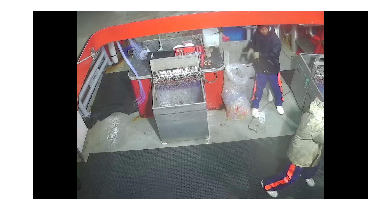

In [0]:
img_pil = read_rand_img('NoF')

plt.axis('off')
plt.imshow(img_pil);

In [0]:
# output the predictions
img_tensor = preprocess(img_pil).type(dtype)   # (1, 3, 224, 224)
probs, idx = get_preds(img_tensor, net)
idx[:5]

array([0, 7, 4, 1, 6])

In [0]:
# see the output classes
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], label_clss[idx[i]]))

0.994 -> NoF
0.004 -> ALB
0.001 -> OTHER
0.001 -> DOL
0.001 -> YFT


In [0]:
final_conv_feature = extract_feature(img_tensor).detach().clone()   # output of final conv layer (after relu)
CAMs = returnCAM(final_conv_feature, [idx[0], idx[2]])

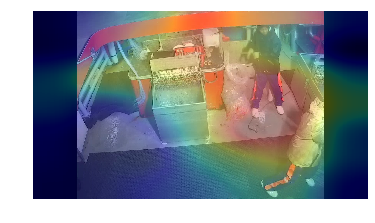

In [0]:
width, height = img_pil.size
heatmap = imresize(CAMs[0], (width, height))

plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.3)
plt.show()

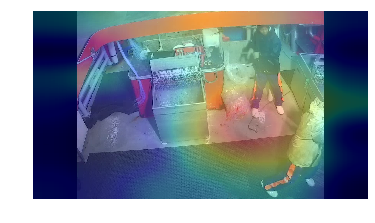

In [0]:
width, height = img_pil.size
heatmap = imresize(CAMs[1], (width, height))

plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.3)
plt.show()

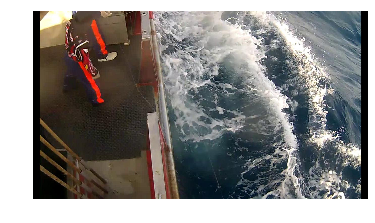

In [0]:
img_pil = read_rand_img('NoF')

plt.axis('off')
plt.imshow(img_pil);

In [0]:
# output the predictions
img_tensor = preprocess(img_pil).type(dtype)   # (1, 3, 224, 224)
probs, idx = get_preds(img_tensor, net)
idx[:5]

array([0, 7, 3, 1, 6])

In [0]:
# see the output classes
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], label_clss[idx[i]]))

0.716 -> NoF
0.099 -> ALB
0.050 -> BET
0.049 -> DOL
0.045 -> YFT


In [0]:
final_conv_feature = extract_feature(img_tensor).detach().clone()   # output of final conv layer (after relu)
CAMs = returnCAM(final_conv_feature, [idx[0], idx[1]])

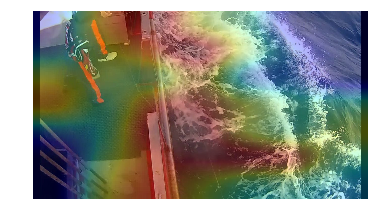

In [0]:
width, height = img_pil.size
heatmap = imresize(CAMs[0], (width, height))

plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.3)
plt.show()

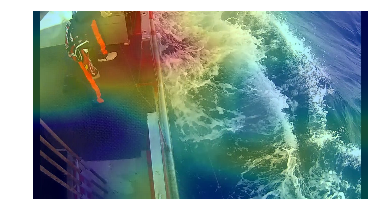

In [0]:
heatmap = imresize(CAMs[1], (width, height))

plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.3)
plt.show()

### Test set

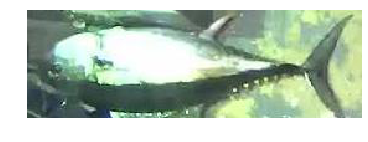

In [0]:
f = np.random.choice(os.listdir(data_path+'/test_cls/'), 1)[0]
img_pil = Image.open(os.path.join(data_path,'test_cls',f))

plt.axis('off')
plt.imshow(img_pil)

In [0]:
# output the predictions
img_tensor = preprocess(img_pil).type(dtype)   # (1, 3, 224, 224)
probs, idx = get_preds(img_tensor, net)
idx[:5]

array([7, 4, 6, 1, 3])

In [0]:
# see the output classes
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], label_clss[idx[i]]))

0.430 -> ALB
0.256 -> OTHER
0.093 -> YFT
0.073 -> DOL
0.048 -> BET


In [0]:
final_conv_feature = extract_feature(img_tensor).detach().clone()   # output of final conv layer (after relu)
CAMs = returnCAM(final_conv_feature, [idx[0], idx[1]])

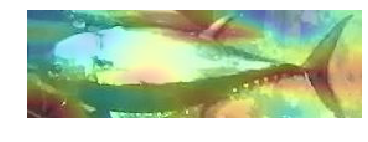

In [0]:
width, height = img_pil.size
heatmap = imresize(CAMs[0], (width, height))

plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.3)
plt.show()

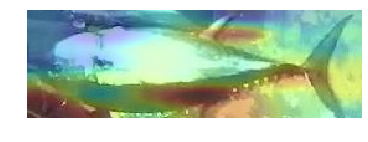

In [0]:
heatmap = imresize(CAMs[1], (width, height))

plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.3)
plt.show()

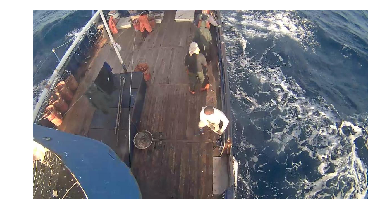

In [0]:
f = np.random.choice(os.listdir(data_path+'/test_cls/'), 1)[0]
img_pil = Image.open(os.path.join(data_path,'test_cls',f))

plt.axis('off')
plt.imshow(img_pil)

In [0]:
# output the predictions
img_tensor = preprocess(img_pil).type(dtype)   # (1, 3, 224, 224)
probs, idx = get_preds(img_tensor, net)
idx[:5]

array([4, 7, 6, 0, 5])

In [0]:
# see the output classes
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], label_clss[idx[i]]))

0.279 -> OTHER
0.234 -> ALB
0.135 -> YFT
0.109 -> NoF
0.108 -> SHARK


In [0]:
final_conv_feature = extract_feature(img_tensor).detach().clone()   # output of final conv layer (after relu)
CAMs = returnCAM(final_conv_feature, [idx[0], idx[3]])

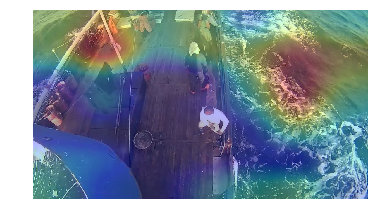

In [0]:
width, height = img_pil.size
heatmap = imresize(CAMs[0], (width, height))

plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.3)
plt.show()

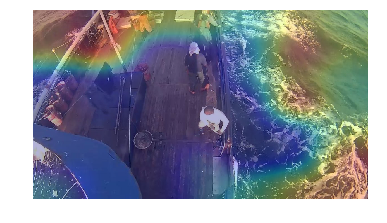

In [0]:
heatmap = imresize(CAMs[1], (width, height))

plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.3)
plt.show()

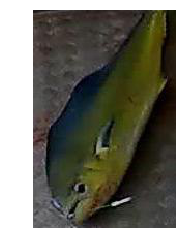

In [0]:
# obviously a dolphinfish (DOL)
f = np.random.choice(os.listdir(data_path+'/test_cls/'), 1)[0]
img_pil = Image.open(os.path.join(data_path,'test_cls',f))

plt.axis('off')
plt.imshow(img_pil);

In [0]:
# output the predictions
img_tensor = preprocess(img_pil).type(dtype)   # (1, 3, 224, 224)
probs, idx = get_preds(img_tensor, net)
idx[:5]

array([7, 3, 6, 4, 5])

In [0]:
# see the output classes
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], label_clss[idx[i]]))

0.729 -> ALB
0.085 -> BET
0.060 -> YFT
0.056 -> OTHER
0.035 -> SHARK


In [0]:
final_conv_feature = extract_feature(img_tensor).detach().clone()   # output of final conv layer (after relu)
CAMs = returnCAM(final_conv_feature, [idx[0], idx[1]])

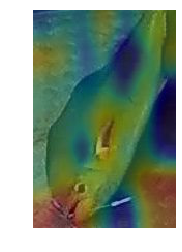

In [0]:
width, height = img_pil.size
heatmap = imresize(CAMs[0], (width, height))

plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.3)
plt.show()

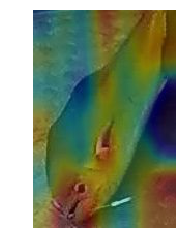

In [0]:
heatmap = imresize(CAMs[1], (width, height))

plt.axis('off')
plt.imshow(img_pil)
plt.imshow(heatmap, cmap='jet', alpha=0.3)
plt.show()